In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Pipeline Preprocessing

### DB1: Transactions

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRockLogistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';')
#trans_df.head()

In [3]:
trans_df = trans_df[trans_df['T_DOC_TYPE'] == 'COL']
trans_df = trans_df.drop(['T_ACT_HAND_IN_QTY', 'T_DOC_TYPE', 'T_DOC_ID'], axis = 1)
#trans_df.head()

In [4]:
trans_df = trans_df[trans_df['T_STATUS '] == 'EFF']
trans_df = trans_df.drop('T_STATUS ', axis = 1)
#trans_df.head()

In [5]:
trans_df = trans_df[trans_df['T_RTI_NAME'] == 'CC Container Base']
trans_df = trans_df.drop(['T_RTI_NAME', 'T_RTI_ID'], axis = 1)
#trans_df.head()

In [6]:
trans_df = trans_df.drop(['T_DOC_DATE', 'T_PLANNED_DATE'], axis = 1)
trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.drop('T_EFFECTIVE_DATE', axis = 1)
trans_df['Date'] = pd.to_datetime(trans_df['Date'])

In [7]:
trans_df = trans_df.set_index('Date')
#trans_df.head()

In [8]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54982 entries, 2014-07-09 to 2019-04-19
Data columns (total 7 columns):
T_DEL_LOC_ID          0 non-null float64
T_CARRIER_NAME        13733 non-null object
T_SENDING_ID          54982 non-null int64
T_RECEIVING_ID        54982 non-null int64
T_ACT_HAND_OUT_QTY    54982 non-null int64
T_PLANNED_QTY         54982 non-null int64
T_RTI_STATE           54982 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 3.4+ MB


#### are the transacted quantities equal to the planned quantities?

In [9]:
trans_df['T_ACT_HAND_OUT_QTY'].equals(trans_df['T_PLANNED_QTY'])

False

### DB2: Depot Addresses

In [10]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRockLogistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
#depot_add.head()

### Aggregation of DBs

In [11]:
trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop('T_SENDING_ID', axis =1)
#trans_full.head()

In [12]:
trans_full['country'] = trans_full['country'].replace({'GB': 'UK'})
#trans_full

## Transactions in All Countries

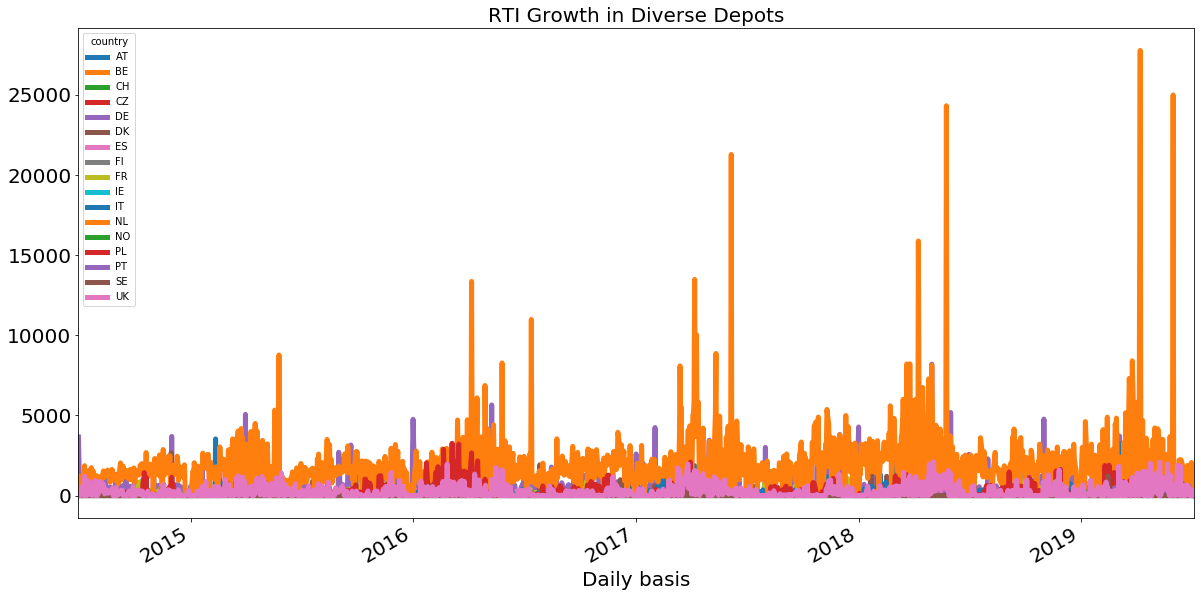

In [13]:
(trans_full.groupby(['Date', 'country'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('country', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily basis', fontsize=20)
plt.show()

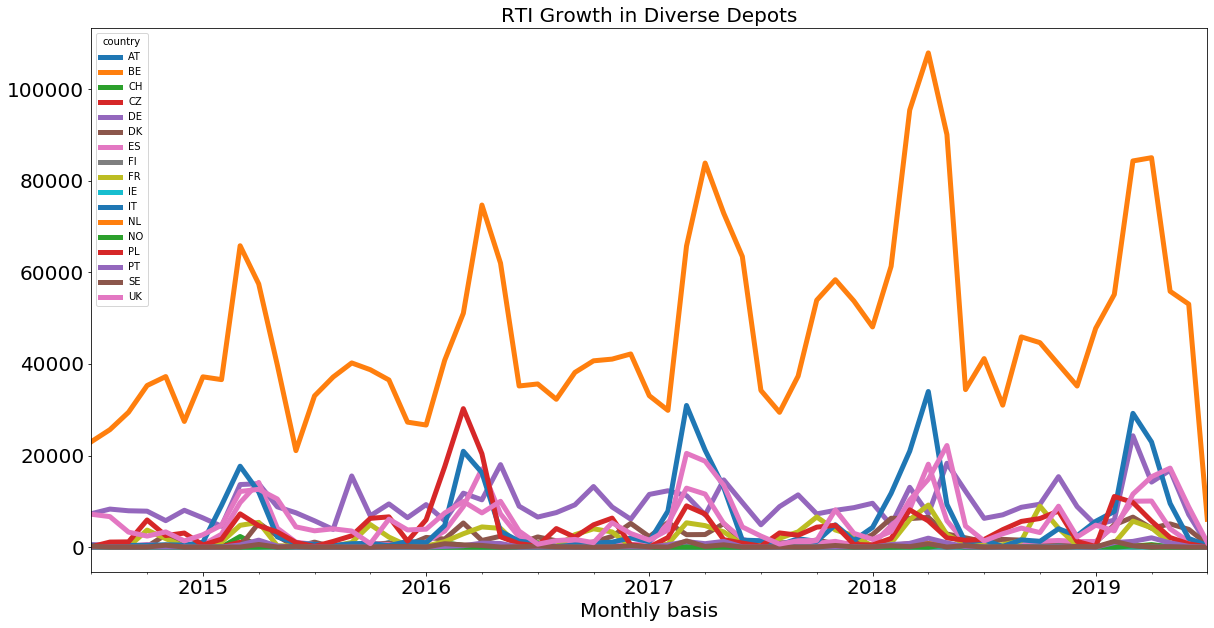

In [14]:
countries = trans_full.groupby(['Date', 'country'])['T_ACT_HAND_OUT_QTY'].sum().unstack('country', fill_value=0)
countries_month = countries.resample('1M').sum()
countries_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly basis', fontsize=20)
plt.show()

In [15]:
countries_month.head()

country,AT,BE,CH,CZ,DE,DK,ES,FI,FR,IE,IT,NL,NO,PL,PT,SE,UK
Date,,,,,,,,,,,,,,,,,
2014-07-31,80,0,0,0,7291,14,574,0,0,0,442,23014,0,71,0,200,7172
2014-08-31,0,0,3,0,8300,35,336,0,0,0,338,25645,0,1094,27,18,6652
2014-09-30,0,0,5,0,7931,0,216,0,75,0,362,29445,0,1140,0,0,3268
2014-10-31,0,0,3,0,7842,114,571,0,3715,0,394,35284,0,5920,31,18,2401
2014-11-30,0,0,0,320,5777,2697,160,69,1844,0,509,37241,0,2515,6,414,3316


## OLS Regression Analysis

In [16]:
import statsmodels.api as sm

In [17]:
XVar = countries_month.drop('NL', axis = 1)
YVar = countries_month['NL']

In [18]:
linearModel = sm.OLS(YVar, XVar).fit()

In [19]:
print(linearModel.summary())

                                 OLS Regression Results                                
Dep. Variable:                     NL   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              51.28
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                    1.60e-23
Time:                        14:05:09   Log-Likelihood:                         -657.21
No. Observations:                  61   AIC:                                      1346.
Df Residuals:                      45   BIC:                                      1380.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Choice of the Most Significant Countries to Netherlands

In [20]:
X_sig = countries_month[['DE', 'BE', 'FR', 'DK', 'UK', 'IE']]

In [21]:
linearModel1 = sm.OLS(YVar, X_sig).fit()

In [22]:
print(linearModel1.summary())

                                 OLS Regression Results                                
Dep. Variable:                     NL   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              136.3
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                    3.57e-31
Time:                        14:05:09   Log-Likelihood:                         -663.07
No. Observations:                  61   AIC:                                      1338.
Df Residuals:                      55   BIC:                                      1351.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
countries_month['OLSed_NL'] = 2.3543 * countries_month['DE'] + 26.4153 * countries_month['BE'] + 2.9990 * countries_month['FR'] + 2.7418 * countries_month['DK'] + 1.3573 * countries_month['UK'] - 146.4090 * countries_month['IE']

### Comparison of Transactions in Netherlands achieved via: 
NL's correlation with other countries (OLSed_NL) vs. registered historical data (NL)

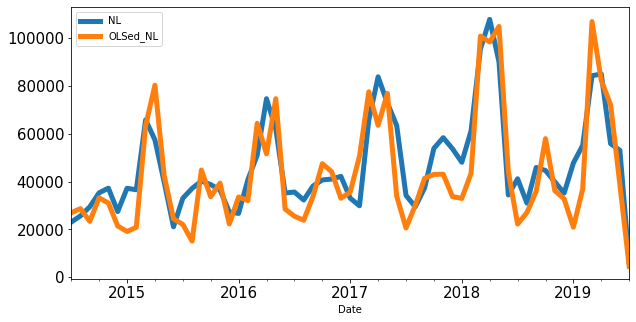

In [24]:
pd.concat([countries_month['NL'],countries_month['OLSed_NL']],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)